In [1]:
import os
from astropy.table import Table,join
import pickle

In [2]:
file_dir='./temp/ill_test/' #directory where files for corr_pc will be placed. I recommend using full path rather than relative path as here.
file_name='ill_test_ED'  #prefix to be appended to the files being saved. Should be different for different datasets.

os.makedirs(file_dir,exist_ok=True)

In [3]:
""" this function generates the input file for corr_pc
 corr_pc takes two samples to compute cross correlations. 
 Shape sample: Sample of galaxies with shapes. For density correlations it is not necessary to pass shapes. 
               Prefix of filenames for this sample should be passed vias file_nameS
 Density sample: Sample of galaxies/particles that trace density field. For density correlations it is not necessary to pass shapes. 
                 If shapes are passed for this sample, w++ can be computed. Prefix of filenames for this sample should be passed vias file_nameD.
                 If auto correlation is to be computed, simply set file_nameD=file_nameS.
 file_name: This is the prefix corr_pc will use to save the output files containing two point correlations. Input file to be passed to corr_pc is 
            also saved with this name. input file is saved in file_dir and the outputs are saved in new directory, file_dir+corr_data_out.
 corr: two point correlation to be computed. This should be density-density (wgg,wmm), shape-density (wg+) or shape-shape(w++). 
        When computing wg+, corr_pc will also compute and save wgg by default since pair counting is done anyways. 
        When doing w++, wg+ and wgg are also computed and saved.
 n_shape, n_density: number of galaxies in the shape sample and density sample respectively.
 do_jk: Whether to do jackknifing or not.
 njk: number of jackknife regions. jackknife regions are assumed to be labelled from 0...njk-1.
"""
def inp_gen(file_dir,file_name,file_nameS,file_nameD,corr=5,n_shape=0,n_density=0,njk=100,do_jk=1,Lbox=75):
    s=""
    s=s+"which_corr     "+str(corr)+"\n" #0: density-density, 1: ia: shape-density, 2 ia:shape-shape, 5: ED
    s=s+"coordinates    7"+"\n"  #6: rp-pi, 7:r-mu, 
    s=s+"estimator      0"+"\n"  #0:landy-szalay (LS): cross. works for both auto and cross correlations. For auto, pass same filenames for shape and density samples 
                                 # 1: LS:auto, for auto correlation only
    s=s+"data_sorted     1"+"\n"  #0: no sorting, 1:sorted by z, 2:sorted by dec (y)
    s=s+"use_comoving    1"+"\n"
    s=s+"do_jk           "+str(do_jk)+"\n" #0: no jackknife, 1: do jackknife. jk regions must be passed in a file. are assumed to be from 0..njk-1
    s=s+"sig_crit        0"+"\n" #for weak lensing, not important for ia, gg corrs.

    #following passes information about shape sample
    s=s+"shape_pos       "+file_dir+file_nameS+'_pos.dat'+"\n"  # x, y coordinates
    s=s+"shape_z         "+file_dir+file_nameS+'_z.dat'+"\n"    # z coordinate
    s=s+"shape_e         "+file_dir+file_nameS+'_e.dat'+"\n"    # e1, e2
#     s=s+"shape_wt         "+file_dir+file_nameS+'_wt.dat'+"\n"  # weights on galaxies. If no weighting, pass 0
    s=s+"shape_wt         0"+"\n"
    s=s+"shape_jk        "+file_dir+file_nameS+'_jk.dat'+"\n"   # jackknife regions

    # following passes information about density sample
    s=s+"density_patch   0"+"\n" #for weak lensing, not important for ia, gg corrs.
    s=s+"density_pos     "+file_dir+file_nameD+'_pos.dat'+"\n"  # x, y coordinates
    s=s+"density_z       "+file_dir+file_nameD+'_z.dat'+"\n"    # z coordinate
    s=s+"density_wt       0"+"\n"  # weights on galaxies/particles. If no weighting, pass 0
#     s=s+"density_wt       "+file_dir+file_nameD+'_wt.dat'+"\n"  # weights on galaxies/particles. If no weighting, pass 0
    s=s+"density_jk      "+file_dir+file_nameD+'_jk.dat'+"\n"   # jackknife regions    
    s=s+"density_e      0"+"\n"   #if doing shape-shape, this file should be passed. # e1, e2

    # following passes information about randoms corresponding to shape sample
    s=s+"Srandom_pos      0"+"\n"
    s=s+"Srandom_z        0"+"\n"
    s=s+"Srandoms_wt      0"+"\n"
    s=s+"Srand_jk         0"+"\n"

    # following passes information about randoms corresponding to density sample
    s=s+"Drandom_patch    0"+"\n"
    s=s+"Drandom_pos      0"+"\n"
    s=s+"Drandom_z        0"+"\n"
    s=s+"Drandoms_wt      0"+"\n"
    s=s+"drand_jk         0"+"\n"

    s=s+"distances        0"+"\n"  #not needed for PB
    s=s+"patch_file       0"+"\n"  #not needed for PB
    s=s+"out_file         "+file_dir+"corr_data_out/"+file_name+"_"+"\n"  # prefix for the output files.
    
    os.makedirs(file_dir+"corr_data_out/",exist_ok=True) #directory where outputs are saved.
    
    s=s+"n_threads       0"+"\n"   # number of openmp threads to use. 0== use maximum available.
    s=s+"n_shape         "+str(n_shape)+"\n"  #number of galaxies in shape sample
    s=s+"n_density       "+str(n_density)+"\n"  #number of galaxies in density sample
    s=s+"n_Srand         0"+"\n"
    s=s+"n_Drand         0"+"\n"
    s=s+"rand_subsample  0"+"\n"  #subsample randoms to speed up calculations.
    s=s+"n_jk          "+str(njk)+"\n"  #number of jk regions. regions are assumed to be labelled from 0....njk-1
    s=s+"n_patch         0 "+"\n"#not needed for PB

    s=s+"binR_min        0.1"+"\n"  # rp_min for the bins
    s=s+"binR_max       10"+"\n" # rp_max for the bins
    s=s+"n_bins         10"+"\n" #number of rp bins to use
    s=s+"lin_bin         0"+"\n"  #linear or log bins. 0: log, 1:linear
    s=s+"n_p_bin         1"+"\n"  #number of pi bins to use. When using r-mu, pi==mu. 
    s=s+"pmin         -1"+"\n"  # pi_min (when mu, mu_min=-1)
    s=s+"pmax         1"+"\n"   # pi_max (mu_max=1)
    s=s+"z_min         0"+"\n"    
    s=s+"z_max         300"+"\n" 
    s=s+"dz            0.0001"+"\n" #not needed for PB
    s=s+"z_sep_min     -100"+"\n"  
    s=s+"z_sep_max     100"+"\n"   
    s=s+"periodic_box  1"+"\n"
    s=s+"box_size     "+str(Lbox)+"\n"  #size of the box.

    fil=open(file_dir+file_name+'.inp','w')
    fil.write(s)


In [4]:
"""
This function splits the sim box into a grid in x-y plane. Number of grid splits along each axis are given by njk1, for a total of njk1^2 sub-sample regions.
After this, each point in data (galaxy or particle) is assigned to its sub-sample.
"""
def jk_box(data=[],Lbox=None,njk1=7):
    if Lbox is None:
        Lbox=np.ceil(max(data['x']))
        print('jk_box using Lbox=',Lbox)
    xjk=np.linspace(0,Lbox,njk1+1)
    yjk=np.linspace(0,Lbox,njk1+1)
    jk=np.zeros(len(data))
    jjk=0
    for i in np.arange(njk1):
        xil=xjk[i]
        xih=xjk[i+1]
        x1=data['x']>xil
        x2=data['x']<xih
        for j in np.arange(njk1):
            yil=yjk[j]
            yih=yjk[j+1]
            y1=data['y']>yil
            y2=data['y']<=yih
            jk[x1*x2*y1*y2]=jjk
            jjk+=1
#     jk=np.array(jk,dtype=[('jk','int32')])
    return jk


In [5]:
fname='/hildafs/datasets/IllustrisTNG/TNG100-1/TNG100-1_99_non-reduced_galaxy_shapes_multi_scale_1024_MLP_only_cent.pkl'
with open(fname, "rb") as f:
    S_dat=pickle.load(f)
S_dat['x']=S_dat['gal_pos_x']
S_dat['y']=S_dat['gal_pos_y']
S_dat['z']=S_dat['gal_pos_z']

In [6]:
S_dat['a'].mean()

0.0038732943243422443

In [7]:

# S_dat = Table.read(fname)
S_dat['jk'] = jk_box(data=S_dat)
S_dat.sort('z')



jk_box using Lbox= 75.0


In [8]:
S_dat['e1']=S_dat['dm_av_x']
S_dat['e2']=S_dat['dm_av_y']
S_dat['e3']=S_dat['dm_av_z']

In [9]:
S_dat['e1']**2+S_dat['e2']**2+S_dat['e3']**2

0.9999999999999997
1.0
1.0000000000000004
1.0
0.9999999999999996
1.0
0.9999999999999999
1.0000000000000007
1.0000000000000002
1.0
1.0


In [10]:
Lbox=S_dat['x'].max()

In [11]:
Lbox=75

In [12]:
D_dat=S_dat

In [13]:
'e1' in S_dat.columns

True

In [14]:
"""
Function to write data files in format that can be read by corr_pc
"""
def write_data(data,file_name,file_dir,wt_col=None):
    file_name=file_dir+file_name
    np.savetxt(file_name+'_pos.dat',np.column_stack((data['x'],data['y']))) #x,y position of galaxies
    np.savetxt(file_name+'_z.dat',data['z']) # z position of galaxies
    if 'jk' in data.columns:
        np.savetxt(file_name+'_jk.dat',data['jk'],fmt='%i') #jackknife is read as integer
    if 'e1' in data.columns: #ellipticities. corr_pc takes e1, e2
        np.savetxt(file_name+'_e.dat',np.column_stack((data['e1'],data['e2'],data['e3'])))
    if wt_col is not None: #wt to be applied to each galaxy/particle.
        wt=data[wt_col]*1.
        wt/=wt.mean()
        np.savetxt(file_name+'_wt.dat',wt)

In [15]:
file_nameS=file_name+'_shape'
write_data(data=S_dat,file_name=file_nameS,file_dir=file_dir,)#wt_col='mass')

# file_nameD=file_name+'_density_rand'
# write_data(data=D_dat,file_name=file_nameD,file_dir=file_dir)
file_nameD=file_nameS

In [16]:
S_dat['jk'].min()

0.0

In [17]:
d={}
sep=0
cos1=0
cos2=0
j=1
for i in ['x','y','z']:
    d[i]=(S_dat[i][1]-S_dat[i][0])
    sep+=d[i]**2
    cos1+=d[i]*S_dat['e'+str(j)][0]
    cos2-=d[i]*S_dat['e'+str(j)][1]
    j+=1
sep=np.sqrt(sep)
cos1/=sep
cos2/=sep

In [18]:
sep

40.588123285268615

In [19]:
d

{'x': -11.429977416992188, 'y': 38.94549226760864, 'z': 0.0003175664460286498}

In [20]:
cos1

0.7741269309884793

In [21]:
cos2

0.022733816938238196

In [22]:
(cos1**2+cos2**2)/2-1./3

-0.03343866747622176

In [31]:
do_jk=1

In [32]:
inp_gen(file_dir=file_dir,file_name=file_name,file_nameS=file_nameS,file_nameD=file_nameD,corr=5,n_shape=len(S_dat),n_density=len(D_dat),
        njk=int(S_dat['jk'].max()+1),do_jk=do_jk,Lbox=Lbox) 
#corr=0 will only do wgg like correlation, no shapes. set corr=1 for wg+ and wgg

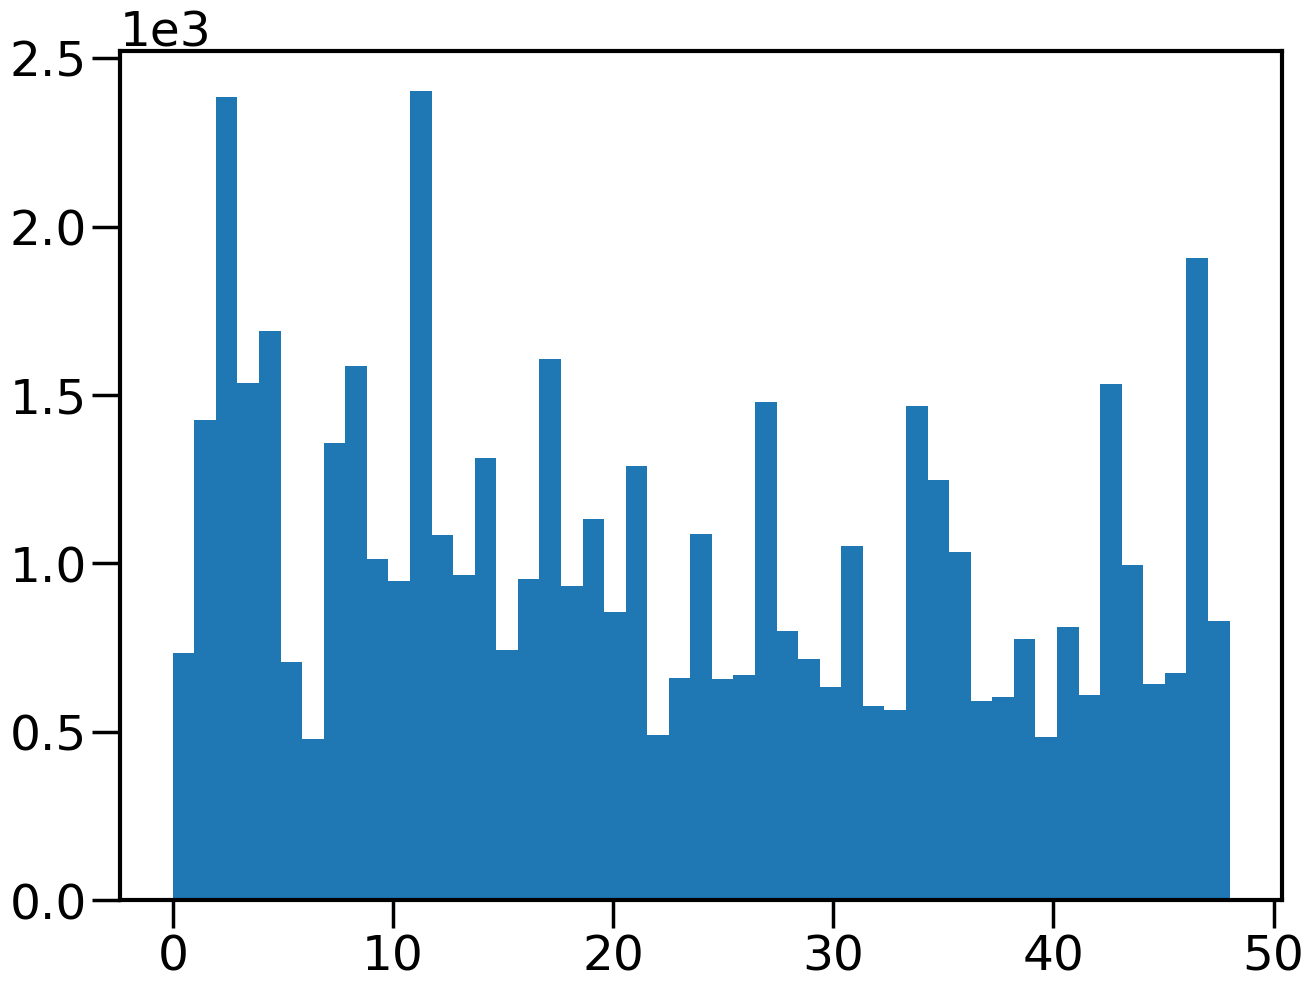

In [25]:
_=hist(S_dat['jk'],int(S_dat['jk'].max()+1))

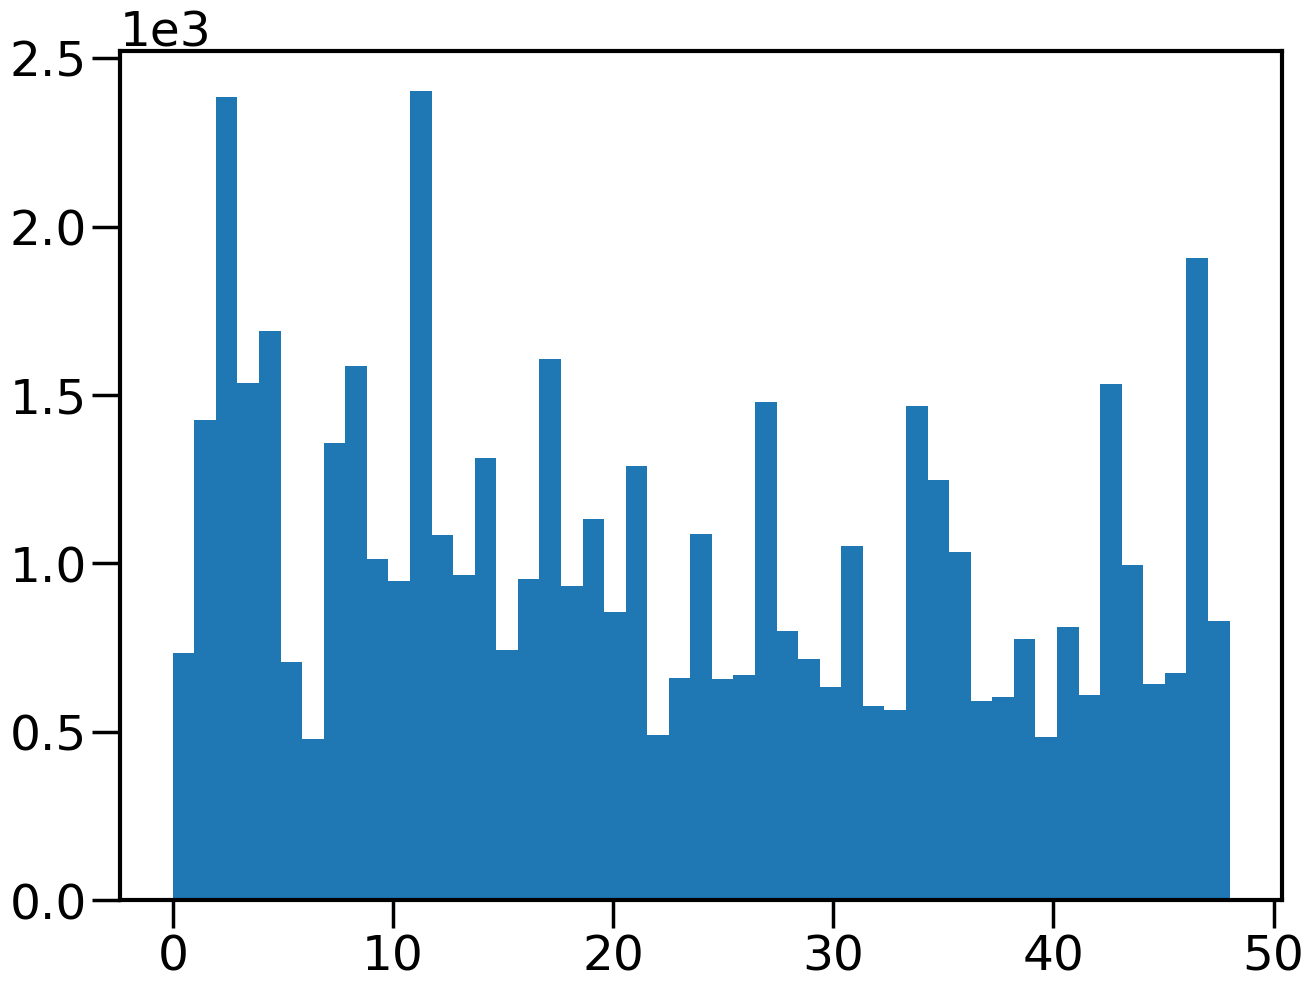

In [26]:
_=hist(D_dat['jk'],int(D_dat['jk'].max()+1))

In [27]:
x=np.arange(10)
y=np.tile(x,3).reshape(3,10).T

In [28]:
y

array([[0, 0, 0],
       [1, 1, 1],
       [2, 2, 2],
       [3, 3, 3],
       [4, 4, 4],
       [5, 5, 5],
       [6, 6, 6],
       [7, 7, 7],
       [8, 8, 8],
       [9, 9, 9]])

In [29]:
import random

In [30]:
random.sample(list(y),3)

[array([3, 3, 3]), array([7, 7, 7]), array([5, 5, 5])]